In [36]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import csv
import cv2
import itertools
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt

from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from IPython.display import clear_output
import winsound
from datetime import datetime
import shutil

In [143]:
class Csv_Preprocessor:
    def preprocess(self, path):
        df = pd.read_csv(path)
        df = df.iloc[:, [i for i in range(51) if i%3] + [53]]
        self.df_X = df.iloc[:,:-1]
        self.df_Y = df.iloc[:,-1]
        hip_center_x = df['LEFT_HIP_x'] + df['RIGHT_HIP_x'] / 2
        hip_center_y = df['LEFT_HIP_y'] + df['RIGHT_HIP_y'] / 2
        shoulder_center_x = df['LEFT_SHOULDER_x'] + df['RIGHT_SHOULDER_x'] / 2
        shoulder_center_y = df['LEFT_SHOULDER_y'] + df['RIGHT_SHOULDER_y'] / 2

        torso_size_dx = hip_center_x - shoulder_center_x
        torso_size_dy = hip_center_y - shoulder_center_y
        torso_length = np.sqrt(torso_size_dx**2 + torso_size_dy**2)

        self.df_X_preprocessed = self.df_X.copy()
        self.df_X_preprocessed.iloc[:, ::2] -= hip_center_x.values.reshape(-1, 1)
        self.df_X_preprocessed.iloc[:, 1::2] -= hip_center_y.values.reshape(-1, 1)
        self.df_X_preprocessed = self.df_X_preprocessed.div(torso_length, axis=0)

    def preprocess_train(self, path):
        self.preprocess(path)
        self.min_val = tf.reduce_min(self.df_X_preprocessed)
        self.max_val = tf.reduce_max(self.df_X_preprocessed)
        df_X_preprocessed = (self.df_X_preprocessed.values - self.min_val) / (self.max_val - self.min_val)

        label = self.df_Y.values
        data = df_X_preprocessed.numpy()
        return data, label, self.df_X.columns

    def preprocess_test(self, path):
        self.preprocess(path)
        df_X_preprocessed = (self.df_X_preprocessed.values - self.min_val) / (self.max_val - self.min_val)

        label = self.df_Y.values
        data = df_X_preprocessed.numpy()
        return data, label, self.df_X.columns

csv_preprocessor = Csv_Preprocessor()

In [184]:
# data, label = preprocess_df(r'train_data.csv')
data, label, bodyparts_name = csv_preprocessor.preprocess_train(r'C:\Users\jinmo\Documents\GitHub\detect-correct-sitting-posture\train_data.csv')

train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

In [185]:
# 인덱스로 사용하기 위해 bool 형태로 변환 합니다.
train_label_bool = np.array(list(map(lambda y: 1 if y == 'normal' else 0, train_label))).astype(bool)
test_label_bool = np.array(list(map(lambda y: 1 if y == 'normal' else 0, test_label))).astype(bool)

In [186]:
# true 값만 사용하여 구성합니다.
normal_train_data = train_data[train_label_bool]
normal_test_data = test_data[test_label_bool]

# false 값만 사용하여 구성합니다.
anomalous_train_data = train_data[~train_label_bool]
anomalous_test_data = test_data[~test_label_bool]

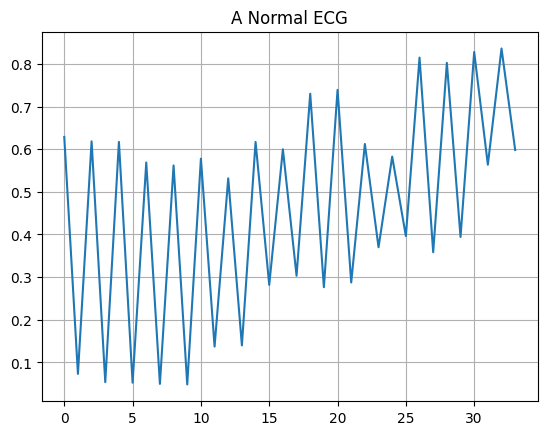

In [147]:
plt.grid()
plt.plot(np.arange(34), normal_train_data[0]) 
plt.title("A Normal ECG")
plt.show()

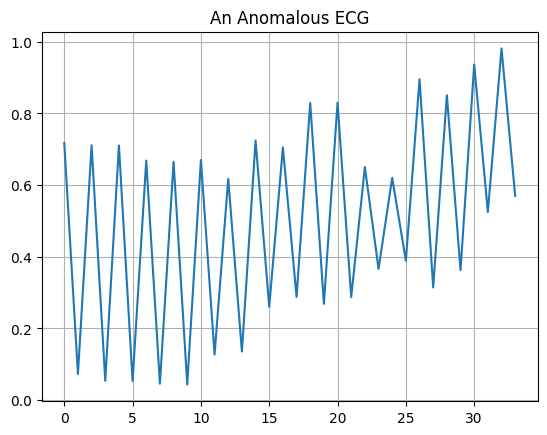

In [148]:
plt.grid()
plt.plot(np.arange(34), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [133]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(25, activation="relu"),
            layers.Dense(20, activation="relu"),
            layers.Dense(15, activation="relu"),
            layers.Dense(10, activation="relu"),
            ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(15, activation="relu"),
            layers.Dense(20, activation="relu"),
            layers.Dense(25, activation="relu"),
            layers.Dense(34, activation="sigmoid")])    # 마지막 층은 원본 데이터의 차원 수와 동일하게 맞추어줍니다.
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [134]:
model = AnomalyDetector()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

In [135]:
history = model.fit(normal_train_data, normal_train_data, 
          epochs=50, 
          batch_size=512,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/50


1/1 [==============================] - 7s 7s/step - loss: 0.2135 - val_loss: 0.2128
Epoch 2/50
1/1 [==============================] - 0s 110ms/step - loss: 0.2127 - val_loss: 0.2122
Epoch 3/50
1/1 [==============================] - 0s 104ms/step - loss: 0.2121 - val_loss: 0.2115
Epoch 4/50
1/1 [==============================] - 0s 109ms/step - loss: 0.2114 - val_loss: 0.2108
Epoch 5/50
1/1 [==============================] - 0s 190ms/step - loss: 0.2106 - val_loss: 0.2100
Epoch 6/50
1/1 [==============================] - 0s 108ms/step - loss: 0.2099 - val_loss: 0.2092
Epoch 7/50
1/1 [==============================] - 0s 138ms/step - loss: 0.2090 - val_loss: 0.2083
Epoch 8/50
1/1 [==============================] - 0s 107ms/step - loss: 0.2082 - val_loss: 0.2074
Epoch 9/50
1/1 [==============================] - 0s 79ms/step - loss: 0.2072 - val_loss: 0.2064
Epoch 10/50
1/1 [==============================] - 0s 127ms/step - loss: 0.2063 - val_loss: 0.2054
Epoch 11/50
1/1 [=================

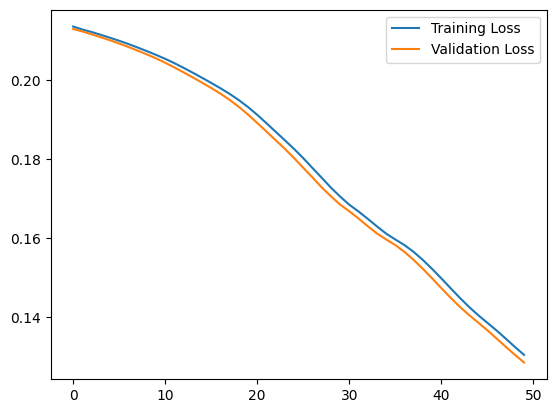

In [136]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
# bodyparts_name

In [ ]:
# encoded_imgs = model.encoder(normal_test_data).numpy()
# decoded_imgs = model.decoder(encoded_imgs).numpy()

# plt.figure(figsize=(10,6))
# plt.plot(normal_test_data[0],'b')
# plt.plot(decoded_imgs[0],'r')
# plt.fill_between(np.arange(34), decoded_imgs[0], normal_test_data[0], color='lightcoral')
# plt.xticks(list(range(len(bodyparts_name))), bodyparts_name, rotation=90)
# plt.legend(labels=["Input", "Reconstruction", "Error"])
# plt.show()

In [ ]:
# encoded_imgs = model.encoder(anomalous_test_data).numpy()
# decoded_imgs = model.decoder(encoded_imgs).numpy()

# plt.figure(figsize=(10,6))
# plt.plot(anomalous_test_data[0],'b')
# plt.plot(decoded_imgs[0],'r')
# plt.fill_between(np.arange(34), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
# plt.xticks(list(range(len(bodyparts_name))), bodyparts_name, rotation=90)
# plt.legend(labels=["Input", "Reconstruction", "Error"])
# plt.show()

In [213]:
anomalous_unique_index = {}
for posture in ['cross_legs', 'forward_head', 'leaning', 'chin_on_hand']:
    anomalous_unique_index[posture] = np.where(test_label == posture)[0][0]
anomalous_unique_index

{'cross_legs': 1, 'forward_head': 5, 'leaning': 6, 'chin_on_hand': 0}

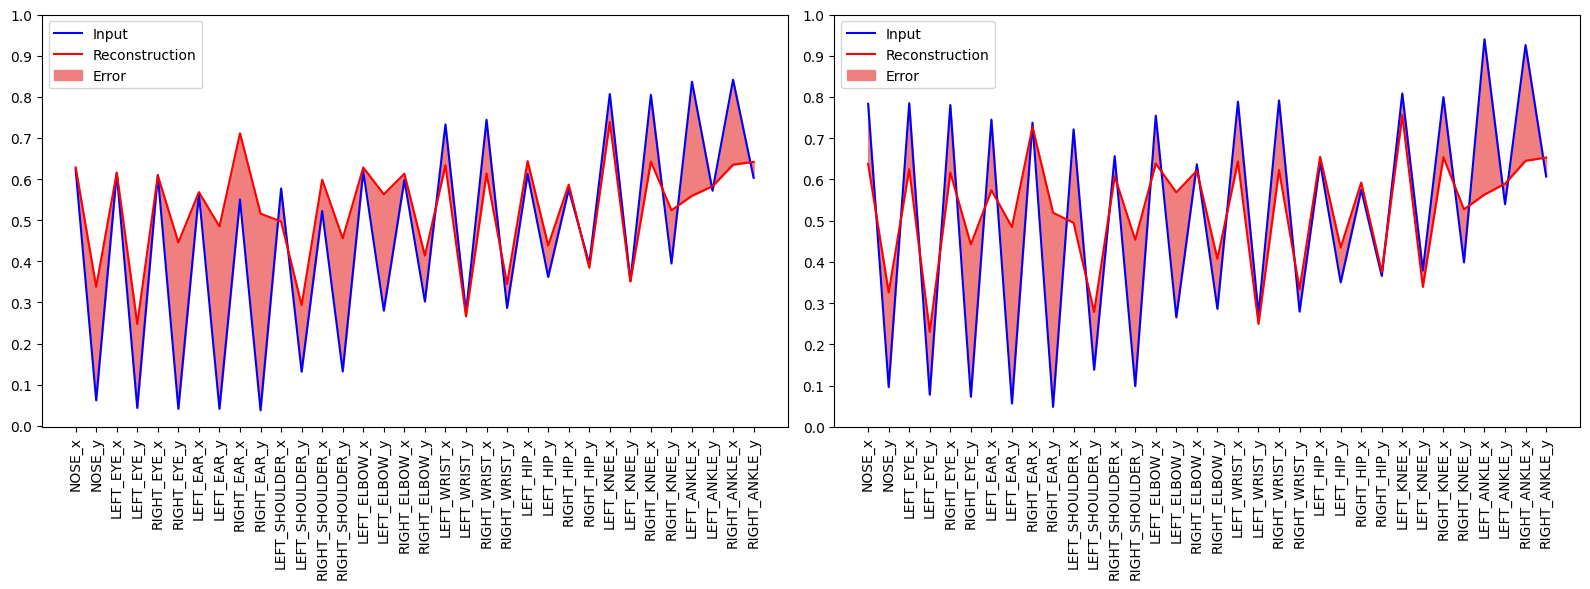

In [218]:
normal_encoded_imgs = model.encoder(normal_test_data).numpy()
normal_decoded_imgs = model.decoder(normal_encoded_imgs).numpy()
anomalous_encoded_imgs = model.encoder(anomalous_test_data).numpy()
anomalous_decoded_imgs = model.decoder(anomalous_encoded_imgs).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6), tight_layout=True)
for idx, (real, decoded) in enumerate(zip((normal_test_data, anomalous_test_data), (normal_decoded_imgs, anomalous_decoded_imgs))):
    axes[idx].plot(real[0],'b')
    axes[idx].plot(decoded[0],'r')
    axes[idx].fill_between(np.arange(34), decoded[0], real[0], color='lightcoral')
    axes[idx].set_xticks(range(len(bodyparts_name)))
    axes[idx].set_xticklabels(bodyparts_name, rotation=90)
    axes[idx].set_yticks(np.arange(0,1.1,0.1))
    axes[idx].legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

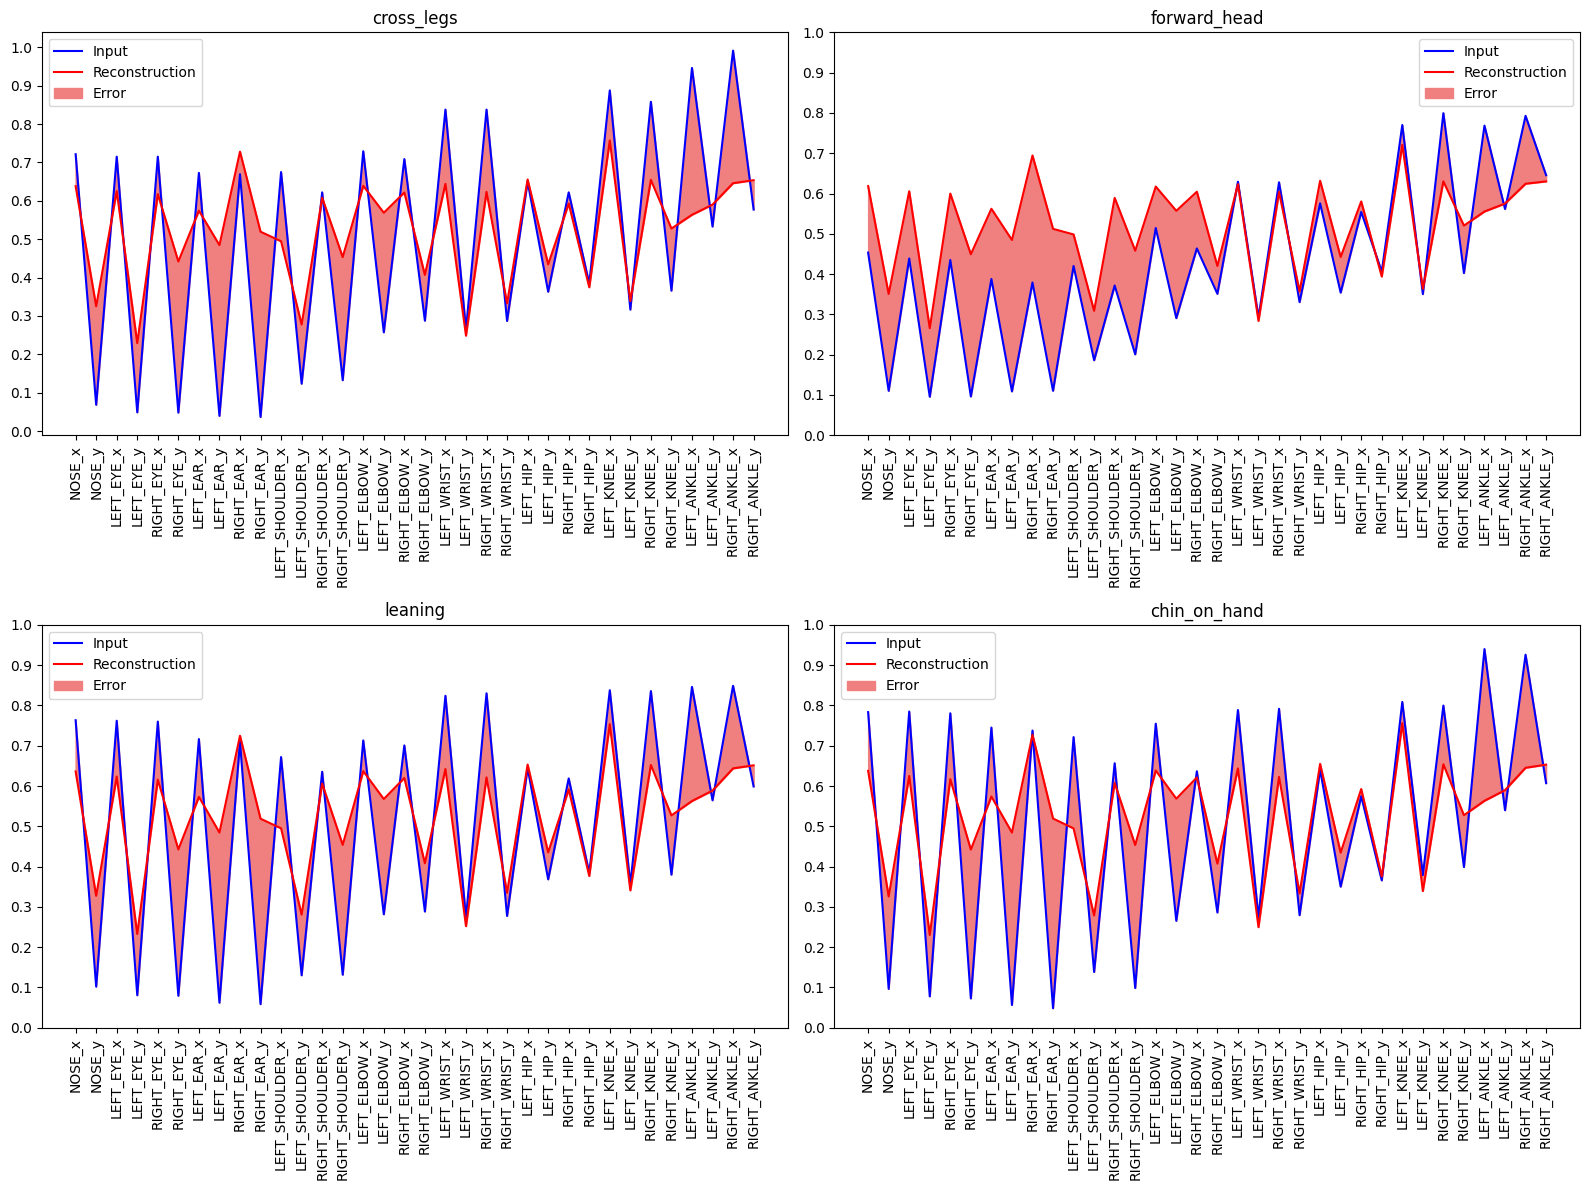

In [217]:
normal_encoded_imgs = model.encoder(normal_test_data).numpy()
normal_decoded_imgs = model.decoder(normal_encoded_imgs).numpy()
anomalous_encoded_imgs = model.encoder(anomalous_test_data).numpy()
anomalous_decoded_imgs = model.decoder(anomalous_encoded_imgs).numpy()

fig, axes = plt.subplots(2, 2, figsize=(16, 12), tight_layout=True)
for ax, (k,v) in zip(axes.ravel(), anomalous_unique_index.items()):
    ax.plot(anomalous_test_data[v],'b')
    ax.plot(anomalous_decoded_imgs[v],'r')
    ax.fill_between(np.arange(34), anomalous_test_data[v], anomalous_decoded_imgs[v], color='lightcoral')
    ax.set_xticks(range(len(bodyparts_name)))
    ax.set_xticklabels(bodyparts_name, rotation=90)
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_title(k)
    ax.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

16/16 [==============================] - 0s 4ms/step


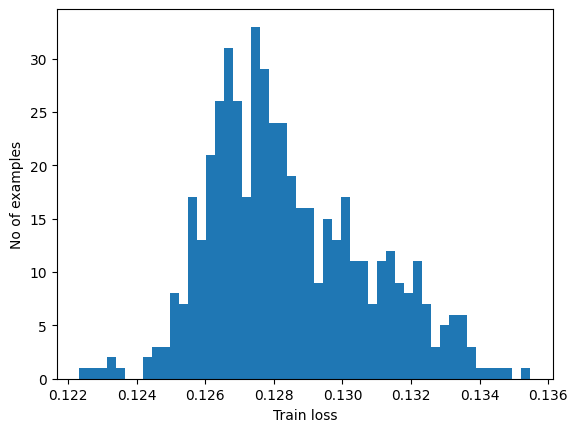

In [139]:
reconstructions = model.predict(normal_train_data)  # model.predict는 값을 numpy array로 배출합니다.
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [140]:
# 위 그래프 보면 right-skewed. 꼬리 자를 threshold 구하기
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.13076182957750462


11/11 [==============================] - 0s 5ms/step


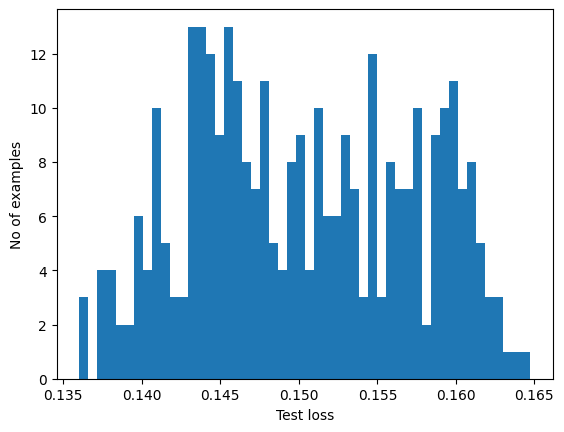

In [141]:
reconstructions = model.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [65]:
def predict(model, data, threshold):
    reconstructions = model(data) # model()은 값을 tensor로 배출합니다.
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold) # 마치 np.array에서 array_ >= threshold처럼. 그때는 proba >= proba_threshold였는데, loss < loss_threshold.

In [66]:
def print_stats(predictions, labels):
    print(f"Accuracy = {accuracy_score(labels, predictions)}")
    print(f"Precision = {precision_score(labels, predictions)}")
    print(f"Recall = {recall_score(labels, predictions)}")

In [150]:
preds = predict(model, test_data, threshold)
print_stats(preds, test_label)

Accuracy = 0.9439461883408071
Precision = 1.0
Recall = 0.7983870967741935


In [151]:
normal_test_preds = predict(model, normal_test_data, threshold)
print_stats(normal_test_preds, len(normal_test_preds)*[1])

Accuracy = 0.7983870967741935
Precision = 1.0
Recall = 0.7983870967741935


In [152]:
anomalous_test_preds = predict(model, anomalous_test_data, threshold)
print_stats(anomalous_test_preds, len(anomalous_test_preds)*[0])

Accuracy = 1.0
Precision = 0.0
Recall = 0.0


c:\Users\jinmo\anaconda3\envs\drowsy\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jinmo\anaconda3\envs\drowsy\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [149]:
model.save('anomaly_weights.keras')

In [23]:
model2 = AnomalyDetector()
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
model2.load_weights('anomaly_weights.keras')

In [24]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [25]:
#@title 추출한 이미지에 포즈 표기 함수

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [26]:
#@title MoveNet 포즈 결과 .csv로 변환하는 클래스

class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          # if not should_keep_image:
          #   self._messages.append('Skipped ' + image_path +
          #                         '. No pose was confidentlly detected.')
          #   continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [32]:
ROOT = r'C:\Users\jinmo\Documents\GitHub\detect-correct-sitting-posture'
def real_time_monitor(path=ROOT, x=5000):
    '실시간 모니터링 함수. x miliseconds마다 자세 분류'
    parentdir = os.path.join(path, r'webcam/running/')
    subdir = os.path.join(parentdir, 'live')
    if not os.path.exists(subdir): os.makedirs(subdir)
    os.chdir(subdir)
    
    # i variable is to give unique name to images
    i = 1
    
    wait = 0
    
    # Open the camera
    video = cv2.VideoCapture(0)
    
    
    while True:
        # Read video by read() function and it
        # will extract and  return the frame
        ret, img = video.read()
    
        # Put current DateTime on each frame
        font = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, str(datetime.now()), (20, 40),
                    font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    
        img = cv2.resize(img, dsize=(540, 960), interpolation=cv2.INTER_AREA)

        # Display the image
        cv2.imshow('live video', img)
    
        # wait for user to press any key
        key = cv2.waitKey(100)
    
        # wait variable is to calculate waiting time
        wait = wait+100
    
        # press q to quit
        if key == ord('q'):
            # 다음 실행 시 예상치 못한 오류 예방하기 위해 남아있는 현 session assets 삭제
            os.chdir(path)
            shutil.rmtree(subdir, ignore_errors=True)
            break
        # when it reaches to x milliseconds
        # we will save that frame in given folder
        if wait == x:
            filename = 'Frame_'+str(i)+'.jpg'
            
            # Save the images in given path
            cv2.imwrite(filename, img)

            # 캡쳐한 이미지 한 장에 대해 MoveNet 실행
            cur_save_dir = os.path.join(path, r'webcam/current_session')
            csv_out_path = os.path.join(cur_save_dir, f'live_{i}.csv')
            preprocessor = MoveNetPreprocessor(
                images_in_folder=parentdir,
                images_out_folder=cur_save_dir,
                csvs_out_path=csv_out_path,
            )

            preprocessor.process(per_pose_class_limit=None)

            # 분류 모델에 입력할 데이터 생성
            X, _, __ = csv_preprocessor.preprocess_test(csv_out_path)

            # 새로운 이미지에 대해서만 데이터를 생성하도록 이미지 이동
            os.replace(os.path.join(parentdir, f'live/Frame_{i}.jpg'), os.path.join(path, f'webcam/current_session/Frame_{i}.jpg'))

            # 모델 예측결과
            y_pred = predict(model, X, threshold)[0]
            y_label = 'normal' if y_pred else 'anomalous'

            # 새로운 결과마다 clear output
            # clear_output()

            # print output
            print(y_label)

            # 자세 올바르지 않으면 알림음 출력
            # 윈도우 버전으로 구성. 기타 OS 환경에서는 별도로 구현하기 바람
            if y_label != 'normal': winsound.Beep(440, 1000)

            i = i+1
            wait = 0
    
    # close the camera
    video.release()
    
    # close open windows
    cv2.destroyAllWindows()
    os.chdir(path)

In [142]:
real_time_monitor()

Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  2.40it/s]



normal


Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  2.27it/s]



abnormal


Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



normal


Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  2.34it/s]



normal


Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  2.68it/s]



normal


Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



normal


Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  2.01it/s]



abnormal


Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  1.99it/s]



abnormal


Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  2.52it/s]



normal


Preprocessing live
100%|██████████| 1/1 [00:01<00:00,  1.52s/it]



abnormal


Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  1.98it/s]



abnormal


Preprocessing live
100%|██████████| 1/1 [00:00<00:00,  2.07it/s]



abnormal


In [152]:
# def sort_files(path):
#     files = os.listdir(path)
#     file_nums = [int(i.split('.')[0][6:]) for i in files if i[0] == 'F']
#     file_nums.sort()
#     sorted_files = ['Frame_' + str(num) + '.jpg' for num in file_nums]
#     return sorted_files

In [192]:
# ROOT = r'C:\Users\jinmo\Documents\GitHub\detect-correct-sitting-posture'
# def real_time_monitor2(posture_path, path=ROOT, x=5000):
#     '실시간 모니터링 함수. x miliseconds마다 자세 분류'
#     parentdir = os.path.join(path, r'webcam/running/')
#     subdir = os.path.join(parentdir, 'live')
#     if not os.path.exists(subdir): os.makedirs(subdir)
#     os.chdir(subdir)

#     # i variable is to give unique name to images
#     i = 1

#     wait = 0

#     # Open the camera
#     video = cv2.VideoCapture(0)

#     img_files = sort_files(posture_path)
#     it = iter(img_files)

#     while True:
#         # Read video by read() function and it
#         # will extract and  return the frame
#         # ret, img = video.read()
#         img = next(it)
#         img = os.path.join(posture_path, img)
#         img = cv2.imread(img)
#         img = cv2.resize(img, dsize=(540, 960), interpolation=cv2.INTER_AREA)

#         # Put current DateTime on each frame
#         font = cv2.FONT_HERSHEY_PLAIN
#         # cv2.putText(img, str(datetime.now()), (20, 40), font, 2, (255, 255, 255), 2, cv2.LINE_AA)

#         # Display the image
#         cv2.imshow('live video', img)

#         # wait for user to press any key
#         key = cv2.waitKey(100)

#         # wait variable is to calculate waiting time
#         wait = wait+100

#         # press q to quit
#         if key == ord('q'):
#             # 다음 실행 시 예상치 못한 오류 예방하기 위해 남아있는 현 session assets 삭제
#             os.chdir(path)
#             shutil.rmtree(subdir, ignore_errors=True)
#             break
#         # when it reaches to x milliseconds
#         # we will save that frame in given folder
#         if wait == x:
#             filename = 'Frame_'+str(i)+'.jpg'

#             # Save the images in given path
#             cv2.imwrite(filename, img)

#             # 캡쳐한 이미지 한 장에 대해 MoveNet 실행
#             cur_save_dir = os.path.join(path, r'webcam/current_session')
#             csv_out_path = os.path.join(cur_save_dir, f'live_{i}.csv')
#             preprocessor = MoveNetPreprocessor(
#                 images_in_folder=parentdir,
#                 images_out_folder=cur_save_dir,
#                 csvs_out_path=csv_out_path,
#             )

#             preprocessor.process(per_pose_class_limit=None)

#             # 분류 모델에 입력할 데이터 생성
#             X = pd.read_csv(csv_out_path)
#             X = X.iloc[:, [i for i in range(51) if i%3]]

#             X = (X.values - min_val) / (max_val - min_val)

#             X = tf.cast(X, tf.float32)

#             # 새로운 이미지에 대해서만 데이터를 생성하도록 이미지 이동
#             os.replace(os.path.join(parentdir, f'live/Frame_{i}.jpg'), os.path.join(path, f'webcam/current_session/Frame_{i}.jpg'))

#             # 모델 예측결과
#             y_pred = predict(model, X, threshold)[0]
#             y_label = 'normal' if y_pred else 'anomalous'

#             # 새로운 결과마다 clear output
#             clear_output()

#             # print output
#             print(y_label)

#             # 자세 올바르지 않으면 알림음 출력
#             # 윈도우 버전으로 구성. 기타 OS 환경에서는 별도로 구현하기 바람
#             if y_label != 'normal': winsound.Beep(440, 1000)

#             i = i+1
#             wait = 0
    
#     # close the camera
#     video.release()
    
#     # close open windows
#     cv2.destroyAllWindows()
#     os.chdir(path)

In [193]:
# # 실행
# real_time_monitor2(r'C:\Users\jinmo\Documents\GitHub\detect-correct-sitting-posture\webcam\poses\chin_on_hand')

abnormal
